In [24]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [26]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [27]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [28]:
tf.keras.backend.clear_session()

In [29]:
subject = 'Piauí - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [30]:
data = pd.read_csv('2003_mo_model_input_PI.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Piauí - Depósito Poupança (R$),Piauí - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí - IDH Longevidade,Piauí - IDH,Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - Consumo de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego
0,2003-1,1.392136e+06,0.578335,0.572145,1002.090457,619.438209,29.774322,22.498674,65.288728,1.531145,0.730178,0.649218,9410.948400,24.669760,21.844,0.605431,2.136063e+07,1.358044e+06,6.061141,1.868149e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.192266
1,2003-2,1.402507e+06,0.578959,0.575756,1002.091633,621.987667,29.768728,22.492857,65.296204,1.530215,0.730506,0.649661,9501.490708,25.167145,15.814,0.605952,2.139102e+07,1.359835e+06,6.065065,1.869506e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.186156
2,2003-3,1.412879e+06,0.579583,0.577863,1002.092318,623.474852,29.765464,22.489463,65.300565,1.529673,0.730835,0.650104,9582.303300,25.520404,16.067,0.606473,2.142142e+07,1.361626e+06,6.068988,1.870864e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.180046
3,2003-4,1.423251e+06,0.580207,0.578089,1002.092392,623.634193,29.765115,22.489100,65.301032,1.529614,0.731163,0.650548,9659.062943,25.519725,14.938,0.606993,2.145181e+07,1.363417e+06,6.072912,1.872222e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.173937
4,2003-5,1.433623e+06,0.580831,0.565428,1001.931726,593.257336,29.985428,22.815550,65.747286,1.500524,0.731492,0.650991,9730.815357,25.929312,17.765,0.607514,2.148221e+07,1.365208e+06,6.076835,1.873580e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.167827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34695.529844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34658.823737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34607.295476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34536.949393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


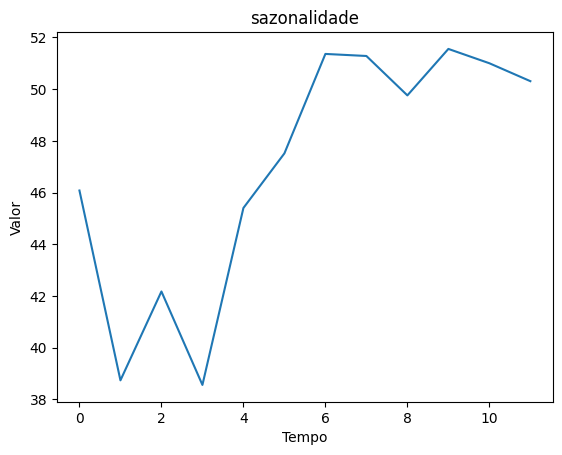

,sazonalidade
sazonalidade,
0,46.079897
1,38.738813
2,42.175584
3,38.561409
4,45.404639
5,47.516156
6,51.362259
7,51.282781
8,49.758880


In [31]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [32]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Piauí - Depósito Poupança (R$),Piauí - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Piauí - IDH Longevidade,Piauí - IDH,Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego,sazonalidade,Piauí - Consumo de Cimento (t)
0,2003-1,1.392136e+06,0.578335,0.572145,1002.090457,619.438209,29.774322,22.498674,65.288728,1.531145,0.730178,0.649218,9410.948400,24.669760,0.605431,2.136063e+07,1.358044e+06,6.061141,1.868149e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.192266,46.079897,21.844
1,2003-2,1.402507e+06,0.578959,0.575756,1002.091633,621.987667,29.768728,22.492857,65.296204,1.530215,0.730506,0.649661,9501.490708,25.167145,0.605952,2.139102e+07,1.359835e+06,6.065065,1.869506e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.186156,38.738813,15.814
2,2003-3,1.412879e+06,0.579583,0.577863,1002.092318,623.474852,29.765464,22.489463,65.300565,1.529673,0.730835,0.650104,9582.303300,25.520404,0.606473,2.142142e+07,1.361626e+06,6.068988,1.870864e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.180046,42.175584,16.067
3,2003-4,1.423251e+06,0.580207,0.578089,1002.092392,623.634193,29.765115,22.489100,65.301032,1.529614,0.731163,0.650548,9659.062943,25.519725,0.606993,2.145181e+07,1.363417e+06,6.072912,1.872222e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.173937,38.561409,14.938
4,2003-5,1.433623e+06,0.580831,0.565428,1001.931726,593.257336,29.985428,22.815550,65.747286,1.500524,0.731492,0.650991,9730.815357,25.929312,0.607514,2.148221e+07,1.365208e+06,6.076835,1.873580e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.167827,45.404639,17.765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34695.529844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.404639,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34658.823737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.516156,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34607.295476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.362259,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34536.949393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.282781,NaN


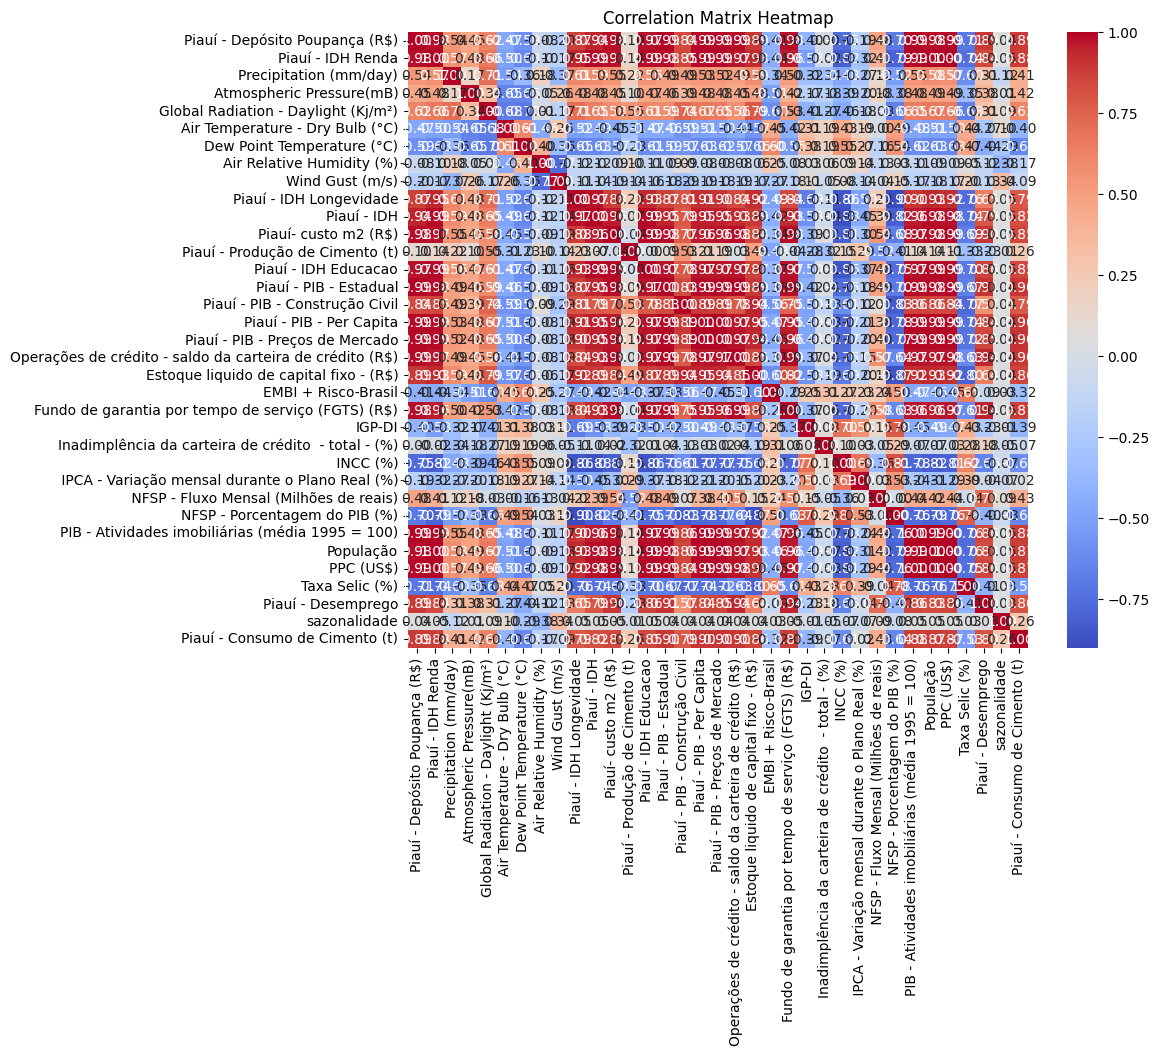

In [33]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [34]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)',
                 'Inadimplência da carteira de crédito  - total - (%)'], axis=1)
data

,Unnamed: 0,Piauí - Depósito Poupança (R$),Piauí - IDH Renda,Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),Piauí - IDH Longevidade,Piauí - IDH,Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego,sazonalidade,Piauí - Consumo de Cimento (t)
0,2003-1,1.392136e+06,0.578335,1002.090457,22.498674,1.531145,0.730178,0.649218,9410.948400,24.669760,0.605431,2.136063e+07,1.358044e+06,6.061141,1.868149e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.192266,46.079897,21.844
1,2003-2,1.402507e+06,0.578959,1002.091633,22.492857,1.530215,0.730506,0.649661,9501.490708,25.167145,0.605952,2.139102e+07,1.359835e+06,6.065065,1.869506e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.186156,38.738813,15.814
2,2003-3,1.412879e+06,0.579583,1002.092318,22.489463,1.529673,0.730835,0.650104,9582.303300,25.520404,0.606473,2.142142e+07,1.361626e+06,6.068988,1.870864e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.180046,42.175584,16.067
3,2003-4,1.423251e+06,0.580207,1002.092392,22.489100,1.529614,0.731163,0.650548,9659.062943,25.519725,0.606993,2.145181e+07,1.363417e+06,6.072912,1.872222e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.173937,38.561409,14.938
4,2003-5,1.433623e+06,0.580831,1001.931726,22.815550,1.500524,0.731492,0.650991,9730.815357,25.929312,0.607514,2.148221e+07,1.365208e+06,6.076835,1.873580e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.167827,45.404639,17.765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34695.529844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.404639,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34658.823737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.516156,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34607.295476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.362259,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34536.949393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.282781,NaN


In [35]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Piauí - Depósito Poupança (R$),Piauí - IDH Renda,Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),Piauí - IDH Longevidade,Piauí - IDH,Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego,sazonalidade
0,0.000000,0.000000,0.433287,0.382694,0.649568,0.000000,0.000000,0.000000,0.231191,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108706,0.015290,1.000000,1.000000,1.000000,0.310283,1.000000,0.000000,0.000000,0.000000,0.813935,0.078897,0.578590
1,0.004006,0.008594,0.433428,0.382220,0.648662,0.014002,0.010908,0.005638,0.245044,0.007575,0.005814,0.017769,0.008894,0.008766,0.000205,0.011007,0.058377,0.004961,0.936603,0.968938,0.921240,0.311059,0.965719,0.001556,0.007992,0.003548,0.698054,0.077028,0.013652
2,0.008012,0.017187,0.433510,0.381944,0.648134,0.028004,0.021817,0.010670,0.254883,0.015150,0.011628,0.035538,0.017788,0.017531,0.000218,0.022015,0.100305,0.000973,0.906543,0.948438,0.873107,0.303979,0.927412,0.003112,0.015984,0.007210,1.000000,0.075160,0.278131
3,0.012017,0.025781,0.433519,0.381914,0.648077,0.042006,0.032725,0.015449,0.254864,0.022725,0.017443,0.053307,0.026682,0.026297,0.000375,0.033022,0.211591,0.000000,0.858675,0.928794,0.851659,0.287789,0.885588,0.004668,0.023976,0.010957,0.629650,0.073291,0.000000
4,0.016023,0.034375,0.414251,0.408501,0.619732,0.056008,0.043633,0.019917,0.266272,0.030300,0.023257,0.071077,0.035577,0.035063,0.000871,0.044030,0.358835,0.002281,0.824839,0.970421,0.823277,0.294233,0.838034,0.006586,0.031968,0.014605,0.795263,0.071422,0.526625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.987151,0.968635,0.531121,0.158930,0.435393,0.840836,0.978318,0.970363,0.028551,0.998709,0.973453,0.793501,0.961232,0.960092,0.974735,0.828698,0.187214,0.826290,0.381401,0.005731,0.000000,0.794606,0.030808,0.978656,0.987600,0.987346,0.075260,0.945259,0.978982
188,0.990363,0.968206,0.483109,0.189129,0.456942,0.834062,0.976544,0.977228,0.020943,0.999031,0.970065,0.797449,0.956913,0.955740,0.979913,0.823090,0.197767,0.819012,0.466609,0.037761,0.029504,0.869001,0.027720,0.985034,0.990700,0.990952,0.052572,0.944716,0.861709
189,0.993575,0.967777,0.482906,0.234429,0.437434,0.827288,0.974770,0.984321,0.013641,0.999354,0.966677,0.801396,0.952594,0.951387,0.987793,0.817482,0.203626,0.880142,0.530936,0.087044,0.043125,0.879026,0.023074,0.991411,0.993800,0.994312,0.013826,0.944172,1.000000
190,0.996788,0.967348,0.486544,0.285325,0.361297,0.820514,0.972996,0.991892,0.006656,0.999677,0.963289,0.805344,0.948275,0.947035,0.994612,0.811875,0.204541,0.957076,0.611274,0.118264,0.059756,0.928863,0.017547,0.995706,0.996900,0.997384,0.056080,0.943629,0.957366


In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      18.413
1      16.605
2      22.084
3      22.445
4      23.323
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Piauí - Consumo de Cimento (t), Length: 249, dtype: float64

In [37]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Piauí - Depósito Poupança (R$),Piauí - IDH Renda,Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),Piauí - IDH Longevidade,Piauí - IDH,Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego,sazonalidade
0,0.000000,0.000000,0.433287,0.382694,0.649568,0.000000,0.000000,0.000000,0.231191,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108706,0.015290,1.000000,1.000000,1.000000,0.310283,1.000000,0.000000,0.000000,0.000000,0.813935,0.078897,0.578590
1,0.004006,0.008594,0.433428,0.382220,0.648662,0.014002,0.010908,0.005638,0.245044,0.007575,0.005814,0.017769,0.008894,0.008766,0.000205,0.011007,0.058377,0.004961,0.936603,0.968938,0.921240,0.311059,0.965719,0.001556,0.007992,0.003548,0.698054,0.077028,0.013652
2,0.008012,0.017187,0.433510,0.381944,0.648134,0.028004,0.021817,0.010670,0.254883,0.015150,0.011628,0.035538,0.017788,0.017531,0.000218,0.022015,0.100305,0.000973,0.906543,0.948438,0.873107,0.303979,0.927412,0.003112,0.015984,0.007210,1.000000,0.075160,0.278131
3,0.012017,0.025781,0.433519,0.381914,0.648077,0.042006,0.032725,0.015449,0.254864,0.022725,0.017443,0.053307,0.026682,0.026297,0.000375,0.033022,0.211591,0.000000,0.858675,0.928794,0.851659,0.287789,0.885588,0.004668,0.023976,0.010957,0.629650,0.073291,0.000000
4,0.016023,0.034375,0.414251,0.408501,0.619732,0.056008,0.043633,0.019917,0.266272,0.030300,0.023257,0.071077,0.035577,0.035063,0.000871,0.044030,0.358835,0.002281,0.824839,0.970421,0.823277,0.294233,0.838034,0.006586,0.031968,0.014605,0.795263,0.071422,0.526625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.849390,0.998221,0.518686,0.324292,0.276835,0.996010,0.990867,0.785165,0.532244,0.950970,0.976314,0.748250,0.974121,0.975577,0.981805,0.956993,0.467381,0.857984,0.039971,0.182507,0.379453,0.469629,0.024030,0.843175,0.890665,0.874793,0.365935,0.999216,0.013652
158,0.855112,0.996442,0.572376,0.323380,0.243991,0.992019,0.991698,0.790548,0.510976,0.954120,0.978467,0.748313,0.976474,0.977798,0.978077,0.953662,0.483414,0.846039,0.027548,0.168812,0.332832,0.458182,0.021531,0.843824,0.893949,0.878731,0.401765,0.998431,0.278131
159,0.860835,0.994663,0.611019,0.262870,0.243861,0.988029,0.992528,0.796122,0.489491,0.957271,0.980620,0.748377,0.978826,0.980018,0.974383,0.950331,0.485402,0.830400,0.037038,0.152959,0.313954,0.439618,0.019385,0.844473,0.897232,0.882759,0.379504,0.997647,0.000000
160,0.866558,0.992884,0.661144,0.176503,0.276114,0.984039,0.993358,0.801639,0.467789,0.960421,0.982774,0.748441,0.981179,0.982238,0.971205,0.947000,0.480289,0.827217,0.070841,0.137613,0.294856,0.456732,0.017671,0.844268,0.900516,0.886861,0.440821,0.996863,0.526625


In [38]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      18.413
1      16.605
2      22.084
3      22.445
4      23.323
        ...  
157    54.656
158    69.984
159    58.643
160    72.337
161    70.968
Name: Piauí - Consumo de Cimento (t), Length: 162, dtype: float64

In [39]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [40]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 29)

In [41]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Piauí - Depósito Poupança (R$),Piauí - IDH Renda,Atmospheric Pressure(mB),Dew Point Temperature (°C),Wind Gust (m/s),Piauí - IDH Longevidade,Piauí - IDH,Piauí- custo m2 (R$),Piauí - Produção de Cimento (t),Piauí - IDH Educacao,Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Piauí - Desemprego,sazonalidade
126,0.830589,0.824462,0.580016,0.128866,0.329243,0.724735,0.720785,0.607879,0.911121,0.696227,0.839906,0.986255,0.918684,0.911178,0.758748,0.994213,0.038989,0.611173,0.201912,0.372054,0.612440,0.198892,0.052718,0.831584,0.780557,0.769083,0.131587,0.690493,0.985098
127,0.836109,0.824756,0.511164,0.095479,0.408076,0.722230,0.720704,0.613394,0.897071,0.699164,0.847037,0.988546,0.924256,0.916950,0.766876,0.995177,0.054581,0.615820,0.209545,0.375438,0.626227,0.212790,0.056653,0.834382,0.784414,0.772016,0.217266,0.706656,0.978982
128,0.841628,0.825050,0.466123,0.101335,0.458548,0.719725,0.720624,0.618920,0.883315,0.702102,0.854168,0.990837,0.929828,0.922721,0.775150,0.996142,0.070743,0.616446,0.238038,0.372254,0.645442,0.219584,0.060771,0.837180,0.788271,0.774681,0.241706,0.722819,0.861709
129,0.847148,0.825344,0.441723,0.134337,0.453630,0.717219,0.720544,0.624409,0.870408,0.705040,0.861300,0.993128,0.935400,0.928493,0.786449,0.997106,0.084331,0.663874,0.249843,0.369458,0.673151,0.215246,0.065105,0.839978,0.792128,0.777064,0.080099,0.738982,1.000000
130,0.852667,0.825638,0.420842,0.189095,0.356360,0.714714,0.720464,0.630014,0.858682,0.707978,0.868431,0.995418,0.940972,0.934265,0.798019,0.998071,0.095511,0.722141,0.266770,0.371547,0.699949,0.236663,0.069099,0.840204,0.795984,0.779225,0.033180,0.755145,0.957366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.987151,0.968635,0.531121,0.158930,0.435393,0.840836,0.978318,0.970363,0.028551,0.998709,0.973453,0.793501,0.961232,0.960092,0.974735,0.828698,0.187214,0.826290,0.381401,0.005731,0.000000,0.794606,0.030808,0.978656,0.987600,0.987346,0.075260,0.945259,0.978982
188,0.990363,0.968206,0.483109,0.189129,0.456942,0.834062,0.976544,0.977228,0.020943,0.999031,0.970065,0.797449,0.956913,0.955740,0.979913,0.823090,0.197767,0.819012,0.466609,0.037761,0.029504,0.869001,0.027720,0.985034,0.990700,0.990952,0.052572,0.944716,0.861709
189,0.993575,0.967777,0.482906,0.234429,0.437434,0.827288,0.974770,0.984321,0.013641,0.999354,0.966677,0.801396,0.952594,0.951387,0.987793,0.817482,0.203626,0.880142,0.530936,0.087044,0.043125,0.879026,0.023074,0.991411,0.993800,0.994312,0.013826,0.944172,1.000000
190,0.996788,0.967348,0.486544,0.285325,0.361297,0.820514,0.972996,0.991892,0.006656,0.999677,0.963289,0.805344,0.948275,0.947035,0.994612,0.811875,0.204541,0.957076,0.611274,0.118264,0.059756,0.928863,0.017547,0.995706,0.996900,0.997384,0.056080,0.943629,0.957366


In [42]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 29)

In [43]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [44]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [45]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(50)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [46]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[671173813, 3837986482, 122364039, 1969583379, 1902538762, 249083188, 3578880775, 271652979, 1149598552, 2745664931, 383333065, 1304692664, 3954135912, 2649276036, 1439635714, 1805586449, 4166391332, 740805812, 3763389713, 1471674253, 1432697089, 3182338255, 1244563808, 1895376340, 3072206476, 151498337, 576699964, 2390196393, 831372493, 2510268179, 1707655391, 1263268531, 450410073, 3892907768, 1297411075, 336200493, 3823316876, 3197430546, 3006105476, 4038311284, 1737875844, 1547773882, 591385362, 4138701430, 3810161096, 3201995638, 414287147, 1948813905, 4087730131, 2125620865]


Step: 0 ___________________________________________
val_loss: 15.46164608001709
winner_seed: 671173813


Step: 1 ___________________________________________
val_loss: 10.471416473388672
winner_seed: 3837986482


Step: 2 ___________________________________________
val_loss: 12.673043251037598


Step: 3 ___________________________________________
val_loss: 12.698629379272461


Step: 4 ________________________

In [47]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 3430781553

Epoch 1/10000
4/4 [==============================] - 2s 127ms/step - loss: 2921.8557 - val_loss: 406.2421
Epoch 2/10000
4/4 [==============================] - 0s 10ms/step - loss: 337.6724 - val_loss: 332.9257
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 355.4090 - val_loss: 438.0115
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 383.6722 - val_loss: 346.8908
Epoch 5/10000
4/4 [==============================] - 0s 12ms/step - loss: 328.9070 - val_loss: 318.5105
Epoch 6/10000
4/4 [==============================] - 0s 10ms/step - loss: 373.9245 - val_loss: 311.8412
Epoch 7/10000
4/4 [==============================] - 0s 11ms/step - loss: 311.5234 - val_loss: 332.5084
Epoch 8/10000
4/4 [==============================] - 0s 11ms/step - loss: 316.7482 - val_loss: 300.0200
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 356.2044 - val_loss: 307.3555
Epoch 10/10000
4/4 [==============================] - 0s 11ms/

4/4 [==============================] - 0s 10ms/step - loss: 95.1200 - val_loss: 78.1539
Epoch 80/10000
4/4 [==============================] - 0s 11ms/step - loss: 96.9819 - val_loss: 67.2397
Epoch 81/10000
4/4 [==============================] - 0s 10ms/step - loss: 79.2386 - val_loss: 88.8440
Epoch 82/10000
4/4 [==============================] - 0s 11ms/step - loss: 64.6696 - val_loss: 83.0910
Epoch 83/10000
4/4 [==============================] - 0s 9ms/step - loss: 63.6548 - val_loss: 66.1726
Epoch 84/10000
4/4 [==============================] - 0s 11ms/step - loss: 62.4971 - val_loss: 101.8563
Epoch 85/10000
4/4 [==============================] - 0s 11ms/step - loss: 69.4007 - val_loss: 69.2858
Epoch 86/10000
4/4 [==============================] - 0s 11ms/step - loss: 63.3602 - val_loss: 92.9598
Epoch 87/10000
4/4 [==============================] - 0s 10ms/step - loss: 80.9283 - val_loss: 75.3126
Epoch 88/10000
4/4 [==============================] - 0s 10ms/step - loss: 59.0080 - val

4/4 [==============================] - 0s 12ms/step - loss: 54.2567 - val_loss: 58.3943
Epoch 159/10000
4/4 [==============================] - 0s 11ms/step - loss: 51.3420 - val_loss: 60.6126
Epoch 160/10000
4/4 [==============================] - 0s 13ms/step - loss: 56.9070 - val_loss: 66.9589
Epoch 161/10000
4/4 [==============================] - 0s 12ms/step - loss: 57.0216 - val_loss: 87.9226
Epoch 162/10000
4/4 [==============================] - 0s 10ms/step - loss: 59.1803 - val_loss: 92.5569
Epoch 163/10000
4/4 [==============================] - 0s 12ms/step - loss: 57.4175 - val_loss: 98.2919
Epoch 164/10000
4/4 [==============================] - 0s 11ms/step - loss: 61.6264 - val_loss: 60.1854
Epoch 165/10000
4/4 [==============================] - 0s 11ms/step - loss: 67.5351 - val_loss: 73.5281
Epoch 166/10000
4/4 [==============================] - 0s 10ms/step - loss: 66.1600 - val_loss: 65.5541
Epoch 167/10000
4/4 [==============================] - 0s 10ms/step - loss: 52.5

Epoch 237/10000
4/4 [==============================] - 0s 10ms/step - loss: 49.5093 - val_loss: 52.7433
Epoch 238/10000
4/4 [==============================] - 0s 10ms/step - loss: 56.6279 - val_loss: 70.0324
Epoch 239/10000
4/4 [==============================] - 0s 9ms/step - loss: 63.2216 - val_loss: 50.5977
Epoch 240/10000
4/4 [==============================] - 0s 9ms/step - loss: 48.9081 - val_loss: 57.9790
Epoch 241/10000
4/4 [==============================] - 0s 11ms/step - loss: 46.7827 - val_loss: 50.8943
Epoch 242/10000
4/4 [==============================] - 0s 12ms/step - loss: 46.2975 - val_loss: 61.6715
Epoch 243/10000
4/4 [==============================] - 0s 9ms/step - loss: 57.7255 - val_loss: 61.5197
Epoch 244/10000
4/4 [==============================] - 0s 12ms/step - loss: 49.0977 - val_loss: 54.4392
Epoch 245/10000
4/4 [==============================] - 0s 11ms/step - loss: 51.7263 - val_loss: 54.6447
Epoch 246/10000
4/4 [==============================] - 0s 10ms/step

Epoch 316/10000
4/4 [==============================] - 0s 10ms/step - loss: 49.4920 - val_loss: 55.3397
Epoch 317/10000
4/4 [==============================] - 0s 11ms/step - loss: 49.4552 - val_loss: 51.4348
Epoch 318/10000
4/4 [==============================] - 0s 11ms/step - loss: 42.5454 - val_loss: 59.0783
Epoch 319/10000
4/4 [==============================] - 0s 11ms/step - loss: 45.8211 - val_loss: 84.8547
Epoch 320/10000
4/4 [==============================] - 0s 11ms/step - loss: 50.4885 - val_loss: 59.8367
Epoch 321/10000
4/4 [==============================] - 0s 12ms/step - loss: 39.4217 - val_loss: 50.6461
Epoch 322/10000
4/4 [==============================] - 0s 12ms/step - loss: 35.9318 - val_loss: 46.9882
Epoch 323/10000
4/4 [==============================] - 0s 12ms/step - loss: 46.5703 - val_loss: 82.2459
Epoch 324/10000
4/4 [==============================] - 0s 13ms/step - loss: 65.5819 - val_loss: 70.4493
Epoch 325/10000
4/4 [==============================] - 0s 12ms/s

Epoch 395/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.7259 - val_loss: 34.9621
Epoch 396/10000
4/4 [==============================] - 0s 12ms/step - loss: 23.6684 - val_loss: 25.9145
Epoch 397/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.3301 - val_loss: 21.9966
Epoch 398/10000
4/4 [==============================] - 0s 11ms/step - loss: 35.3022 - val_loss: 151.2554
Epoch 399/10000
4/4 [==============================] - 0s 10ms/step - loss: 122.0380 - val_loss: 35.9158
Epoch 400/10000
4/4 [==============================] - 0s 11ms/step - loss: 47.9985 - val_loss: 36.4733
Epoch 401/10000
4/4 [==============================] - 0s 11ms/step - loss: 32.2563 - val_loss: 28.7188
Epoch 402/10000
4/4 [==============================] - 0s 12ms/step - loss: 24.4448 - val_loss: 28.0365
Epoch 403/10000
4/4 [==============================] - 0s 12ms/step - loss: 24.3061 - val_loss: 23.2658
Epoch 404/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 10ms/step - loss: 15.1447 - val_loss: 24.4400
Epoch 475/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.9929 - val_loss: 19.9713
Epoch 476/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.8656 - val_loss: 17.9794
Epoch 477/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.2029 - val_loss: 16.6810
Epoch 478/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.6833 - val_loss: 23.6675
Epoch 479/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.2597 - val_loss: 30.5289
Epoch 480/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.4220 - val_loss: 15.7998
Epoch 481/10000
4/4 [==============================] - 0s 10ms/step - loss: 23.3884 - val_loss: 19.5421
Epoch 482/10000
4/4 [==============================] - 0s 10ms/step - loss: 18.6458 - val_loss: 20.1590
Epoch 483/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.1703

4/4 [==============================] - 0s 10ms/step - loss: 14.8452 - val_loss: 26.6992
Epoch 554/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.8182 - val_loss: 16.4227
Epoch 555/10000
4/4 [==============================] - 0s 12ms/step - loss: 15.5191 - val_loss: 19.6780
Epoch 556/10000
4/4 [==============================] - 0s 12ms/step - loss: 14.7314 - val_loss: 21.7298
Epoch 557/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.3597 - val_loss: 18.7946
Epoch 558/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.1059 - val_loss: 20.8438
Epoch 559/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.7495 - val_loss: 18.0557
Epoch 560/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.8425 - val_loss: 15.5154
Epoch 561/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.3867 - val_loss: 20.1202
Epoch 562/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.4

Epoch 632/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.8942 - val_loss: 16.4533
Epoch 633/10000
4/4 [==============================] - 0s 12ms/step - loss: 18.3010 - val_loss: 73.0665
Epoch 634/10000
4/4 [==============================] - 0s 13ms/step - loss: 32.9515 - val_loss: 22.3649
Epoch 635/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.8453 - val_loss: 17.2525
Epoch 636/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.0701 - val_loss: 18.2340
Epoch 637/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.3790 - val_loss: 41.6812
Epoch 638/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.1898 - val_loss: 18.5328
Epoch 639/10000
4/4 [==============================] - 0s 12ms/step - loss: 15.2663 - val_loss: 18.2729
Epoch 640/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.3153 - val_loss: 20.4479
Epoch 641/10000
4/4 [==============================] - 0s 11ms/s

Epoch 711/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.3744 - val_loss: 14.0177
Epoch 712/10000
4/4 [==============================] - 0s 12ms/step - loss: 14.0776 - val_loss: 12.1679
Epoch 713/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.3233 - val_loss: 16.0276
Epoch 714/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.4119 - val_loss: 14.9074
Epoch 715/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.3069 - val_loss: 15.6468
Epoch 716/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.9306 - val_loss: 20.9200
Epoch 717/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.6246 - val_loss: 22.7324
Epoch 718/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.5624 - val_loss: 20.1278
Epoch 719/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.4055 - val_loss: 15.3773
Epoch 720/10000
4/4 [==============================] - 0s 10ms/s

Epoch 790/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.8703 - val_loss: 13.6223
Epoch 791/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.3666 - val_loss: 15.8150
Epoch 792/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.6743 - val_loss: 12.6922
Epoch 793/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.2668 - val_loss: 22.6683
Epoch 794/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.8218 - val_loss: 13.4919
Epoch 795/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.2270 - val_loss: 14.9941
Epoch 796/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.8404 - val_loss: 14.8839
Epoch 797/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.5229 - val_loss: 20.4390
Epoch 798/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.0498 - val_loss: 13.2445
Epoch 799/10000
4/4 [==============================] - 0s 11ms/st

Epoch 869/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.5587 - val_loss: 13.2523
Epoch 870/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.8301 - val_loss: 17.2931
Epoch 871/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.0157 - val_loss: 14.5908
Epoch 872/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.5843 - val_loss: 14.2274
Epoch 873/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.2435 - val_loss: 14.0253
Epoch 874/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.2475 - val_loss: 29.3064
Epoch 875/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.7357 - val_loss: 12.4860
Epoch 876/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.9198 - val_loss: 22.7170
Epoch 877/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.2910 - val_loss: 18.8641
Epoch 878/10000
4/4 [==============================] - 0s 11ms/step 

4/4 [==============================] - 0s 9ms/step - loss: 10.9778 - val_loss: 16.5976
Epoch 949/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.0706 - val_loss: 17.4852
Epoch 950/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.7998 - val_loss: 22.9162
Epoch 951/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.1270 - val_loss: 19.3355
Epoch 952/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.8291 - val_loss: 16.1877
Epoch 953/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.5132 - val_loss: 15.6934
Epoch 954/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.7863 - val_loss: 16.6948
Epoch 955/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.8188 - val_loss: 21.3119
Epoch 956/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.8586 - val_loss: 15.3675
Epoch 957/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.1526 -

4/4 [==============================] - 0s 11ms/step - loss: 11.3182 - val_loss: 16.1368
Epoch 1028/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.7789 - val_loss: 13.5036
Epoch 1029/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.8104 - val_loss: 17.3777
Epoch 1030/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.1915 - val_loss: 17.6764
Epoch 1031/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.2776 - val_loss: 75.2923
Epoch 1032/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.4215 - val_loss: 16.0157
Epoch 1033/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.6460 - val_loss: 25.1489
Epoch 1034/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.8882 - val_loss: 16.3009
Epoch 1035/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.4197 - val_loss: 21.9939
Epoch 1036/10000
4/4 [==============================] - 0s 12ms/step - loss:

4/4 [==============================] - 0s 10ms/step - loss: 8.9769 - val_loss: 26.4516
Epoch 1106/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.5961 - val_loss: 21.8763
Epoch 1107/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.4234 - val_loss: 12.2954
Epoch 1108/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.6602 - val_loss: 20.4799
Epoch 1109/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.1299 - val_loss: 15.8135
Epoch 1110/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.4300 - val_loss: 17.4061
Epoch 1111/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.6253 - val_loss: 24.6514
Epoch 1112/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.7865 - val_loss: 33.8850
Epoch 1113/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.8883 - val_loss: 16.2718
Epoch 1114/10000
4/4 [==============================] - 0s 10ms/step - loss: 1

Epoch 1184/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.3349 - val_loss: 18.9275
Epoch 1185/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.9910 - val_loss: 18.6887
Epoch 1186/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.9311 - val_loss: 20.3630
Epoch 1187/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.7820 - val_loss: 17.7871
Epoch 1188/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.0126 - val_loss: 17.7737
Epoch 1189/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.9329 - val_loss: 24.8602
Epoch 1190/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.6296 - val_loss: 18.5940
Epoch 1191/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.7942 - val_loss: 13.4987
Epoch 1192/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.6313 - val_loss: 17.6742
Epoch 1193/10000
4/4 [==============================] - 0s 10ms

4/4 [==============================] - 0s 9ms/step - loss: 10.2277 - val_loss: 12.5710
Epoch 1263/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.2489 - val_loss: 11.8131
Epoch 1264/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.6964 - val_loss: 15.1467
Epoch 1265/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.1125 - val_loss: 12.6607
Epoch 1266/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.3470 - val_loss: 9.9807
Epoch 1267/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.1464 - val_loss: 21.9222
Epoch 1268/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.0059 - val_loss: 13.3111
Epoch 1269/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.5337 - val_loss: 17.2453
Epoch 1270/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.8897 - val_loss: 13.9961
Epoch 1271/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.2355 - v

Epoch 1341/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.5050 - val_loss: 13.8033
Epoch 1342/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.3072 - val_loss: 11.3840
Epoch 1343/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.4417 - val_loss: 16.3990
Epoch 1344/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.3068 - val_loss: 18.8847
Epoch 1345/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.6395 - val_loss: 14.5164
Epoch 1346/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.2541 - val_loss: 27.8200
Epoch 1347/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.7169 - val_loss: 14.2210
Epoch 1348/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.9047 - val_loss: 22.9280
Epoch 1349/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.6211 - val_loss: 16.9678
Epoch 1350/10000
4/4 [==============================] - 0s 1

4/4 [==============================] - 0s 12ms/step - loss: 9.9824 - val_loss: 13.2870
Epoch 1420/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.3449 - val_loss: 20.7425
Epoch 1421/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.4144 - val_loss: 16.1015
Epoch 1422/10000
4/4 [==============================] - 0s 12ms/step - loss: 8.0057 - val_loss: 16.2810
Epoch 1423/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.7321 - val_loss: 13.6371
Epoch 1424/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.2551 - val_loss: 15.6144
Epoch 1425/10000
4/4 [==============================] - 0s 12ms/step - loss: 7.4353 - val_loss: 14.2755
Epoch 1426/10000
4/4 [==============================] - 0s 12ms/step - loss: 9.1803 - val_loss: 13.2864
Epoch 1427/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.0427 - val_loss: 14.1861
Epoch 1428/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.8

Epoch 1498/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.8646 - val_loss: 22.6016
Epoch 1499/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.1349 - val_loss: 19.5896
Epoch 1500/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.9662 - val_loss: 23.1124
Epoch 1501/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.6913 - val_loss: 37.9234
Epoch 1502/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.8153 - val_loss: 17.1888
Epoch 1503/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.4063 - val_loss: 14.4132
Epoch 1504/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.7224 - val_loss: 17.3886
Epoch 1505/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.0675 - val_loss: 18.1900
Epoch 1506/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.7009 - val_loss: 15.8985
Epoch 1507/10000
4/4 [==============================] - 0s 11

4/4 [==============================] - 0s 11ms/step - loss: 9.3007 - val_loss: 14.8925
Epoch 1577/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.1758 - val_loss: 27.2089
Epoch 1578/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.3419 - val_loss: 26.9918
Epoch 1579/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.4065 - val_loss: 15.9422
Epoch 1580/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.8299 - val_loss: 18.4622
Epoch 1581/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.4438 - val_loss: 12.4435
Epoch 1582/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.1226 - val_loss: 13.2725
Epoch 1583/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.6358 - val_loss: 15.9791
Epoch 1584/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.8992 - val_loss: 21.2859
Epoch 1585/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.173

Epoch 1655/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.8694 - val_loss: 18.9691
Epoch 1656/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.0605 - val_loss: 22.3795
Epoch 1657/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.8550 - val_loss: 18.8162
Epoch 1658/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.1576 - val_loss: 21.8239
Epoch 1659/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.0952 - val_loss: 15.4545
Epoch 1660/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.1969 - val_loss: 13.0343
Epoch 1661/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.4837 - val_loss: 31.9291
Epoch 1662/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.5396 - val_loss: 18.6594
Epoch 1663/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.1116 - val_loss: 18.4692
Epoch 1664/10000
4/4 [==============================] - 0s 11ms/st

4/4 [==============================] - 0s 10ms/step - loss: 7.1372 - val_loss: 11.6413
Epoch 1734/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.3124 - val_loss: 17.8579
Epoch 1735/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.5117 - val_loss: 24.2233
Epoch 1736/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.3358 - val_loss: 14.3041
Epoch 1737/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.4444 - val_loss: 15.2953
Epoch 1738/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.4355 - val_loss: 14.7529
Epoch 1739/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.3806 - val_loss: 16.1405
Epoch 1740/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.8400 - val_loss: 19.0788
Epoch 1741/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.7778 - val_loss: 19.9900
Epoch 1742/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.446

In [48]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [49]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,78.609665,78.113464,75.826851,76.773918,74.288605,71.628761,66.830971,58.869698,62.210804,58.880825,67.929909,71.397675,76.294579,76.0653,74.020309,76.248604,73.600197,70.50811,66.256699,58.730755,61.054565,58.870724,67.305122,70.625664,74.175652,74.693245,73.123436,75.376534,73.373917,70.834465
Target,75.913,74.774,72.484,71.534,70.32,67.364,59.688,40.259,41.239,45.035,42.477,57.619,53.109,63.141,55.58,60.001,62.767,45.308,57.142,46.283,43.39,40.824,55.063,56.474,68.133,68.642,64.741,71.269,67.631,62.845
Error,2.696663,3.339462,3.34285,5.239922,3.968605,4.264763,7.142971,18.610699,20.971806,13.845825,25.452908,13.778675,23.185577,12.924301,18.440308,16.247604,10.833199,25.200111,9.1147,12.447754,17.664566,18.046722,12.242123,14.151665,6.042648,6.051247,8.382439,4.107536,5.74292,7.989464


In [50]:
display(mae)
display(mape)

11.71567

0.22849157

In [51]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [52]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-0: |Prediction[[841.3612]] - Target[718.706]| =  Error: [[122.65521]]; MAPE:[[0.17066118]]
1/1 [==============================] - 0s 17ms/step
Ano-0: |Prediction[[829.5806]] - Target[639.082]| =  Error: [[190.49866]]; MAPE:[[0.29808173]]
1/1 [==============================] - 0s 14ms/step
Ano-5: |Prediction[[441.57727]] - Target[403.26099999999997]| =  Error: [[38.316284]]; MAPE:[[0.09501609]]


[array([[122.65521]], dtype=float32),
 array([[190.49866]], dtype=float32),
 array([[38.316284]], dtype=float32)]

117.156715

0.18791966